In [4]:
import keras
import sys
sys.path.append('../')
from datasets import CD_Dataset
from models import Unet
from utility import show_batches, from_categorical

dataset_path = '../CD_Dataset'
trained_models_path = '../trained_models'

input_patch_size = [350,350]
input_channels = [3]
output_channels = [2]

dataset = CD_Dataset( path=dataset_path, fit=False, download=True, num_classes=output_channels[0] )



xs shape (10, 350, 350, 3)
ys shape (10, 350, 350, 2)
xs type float64
ys type float64


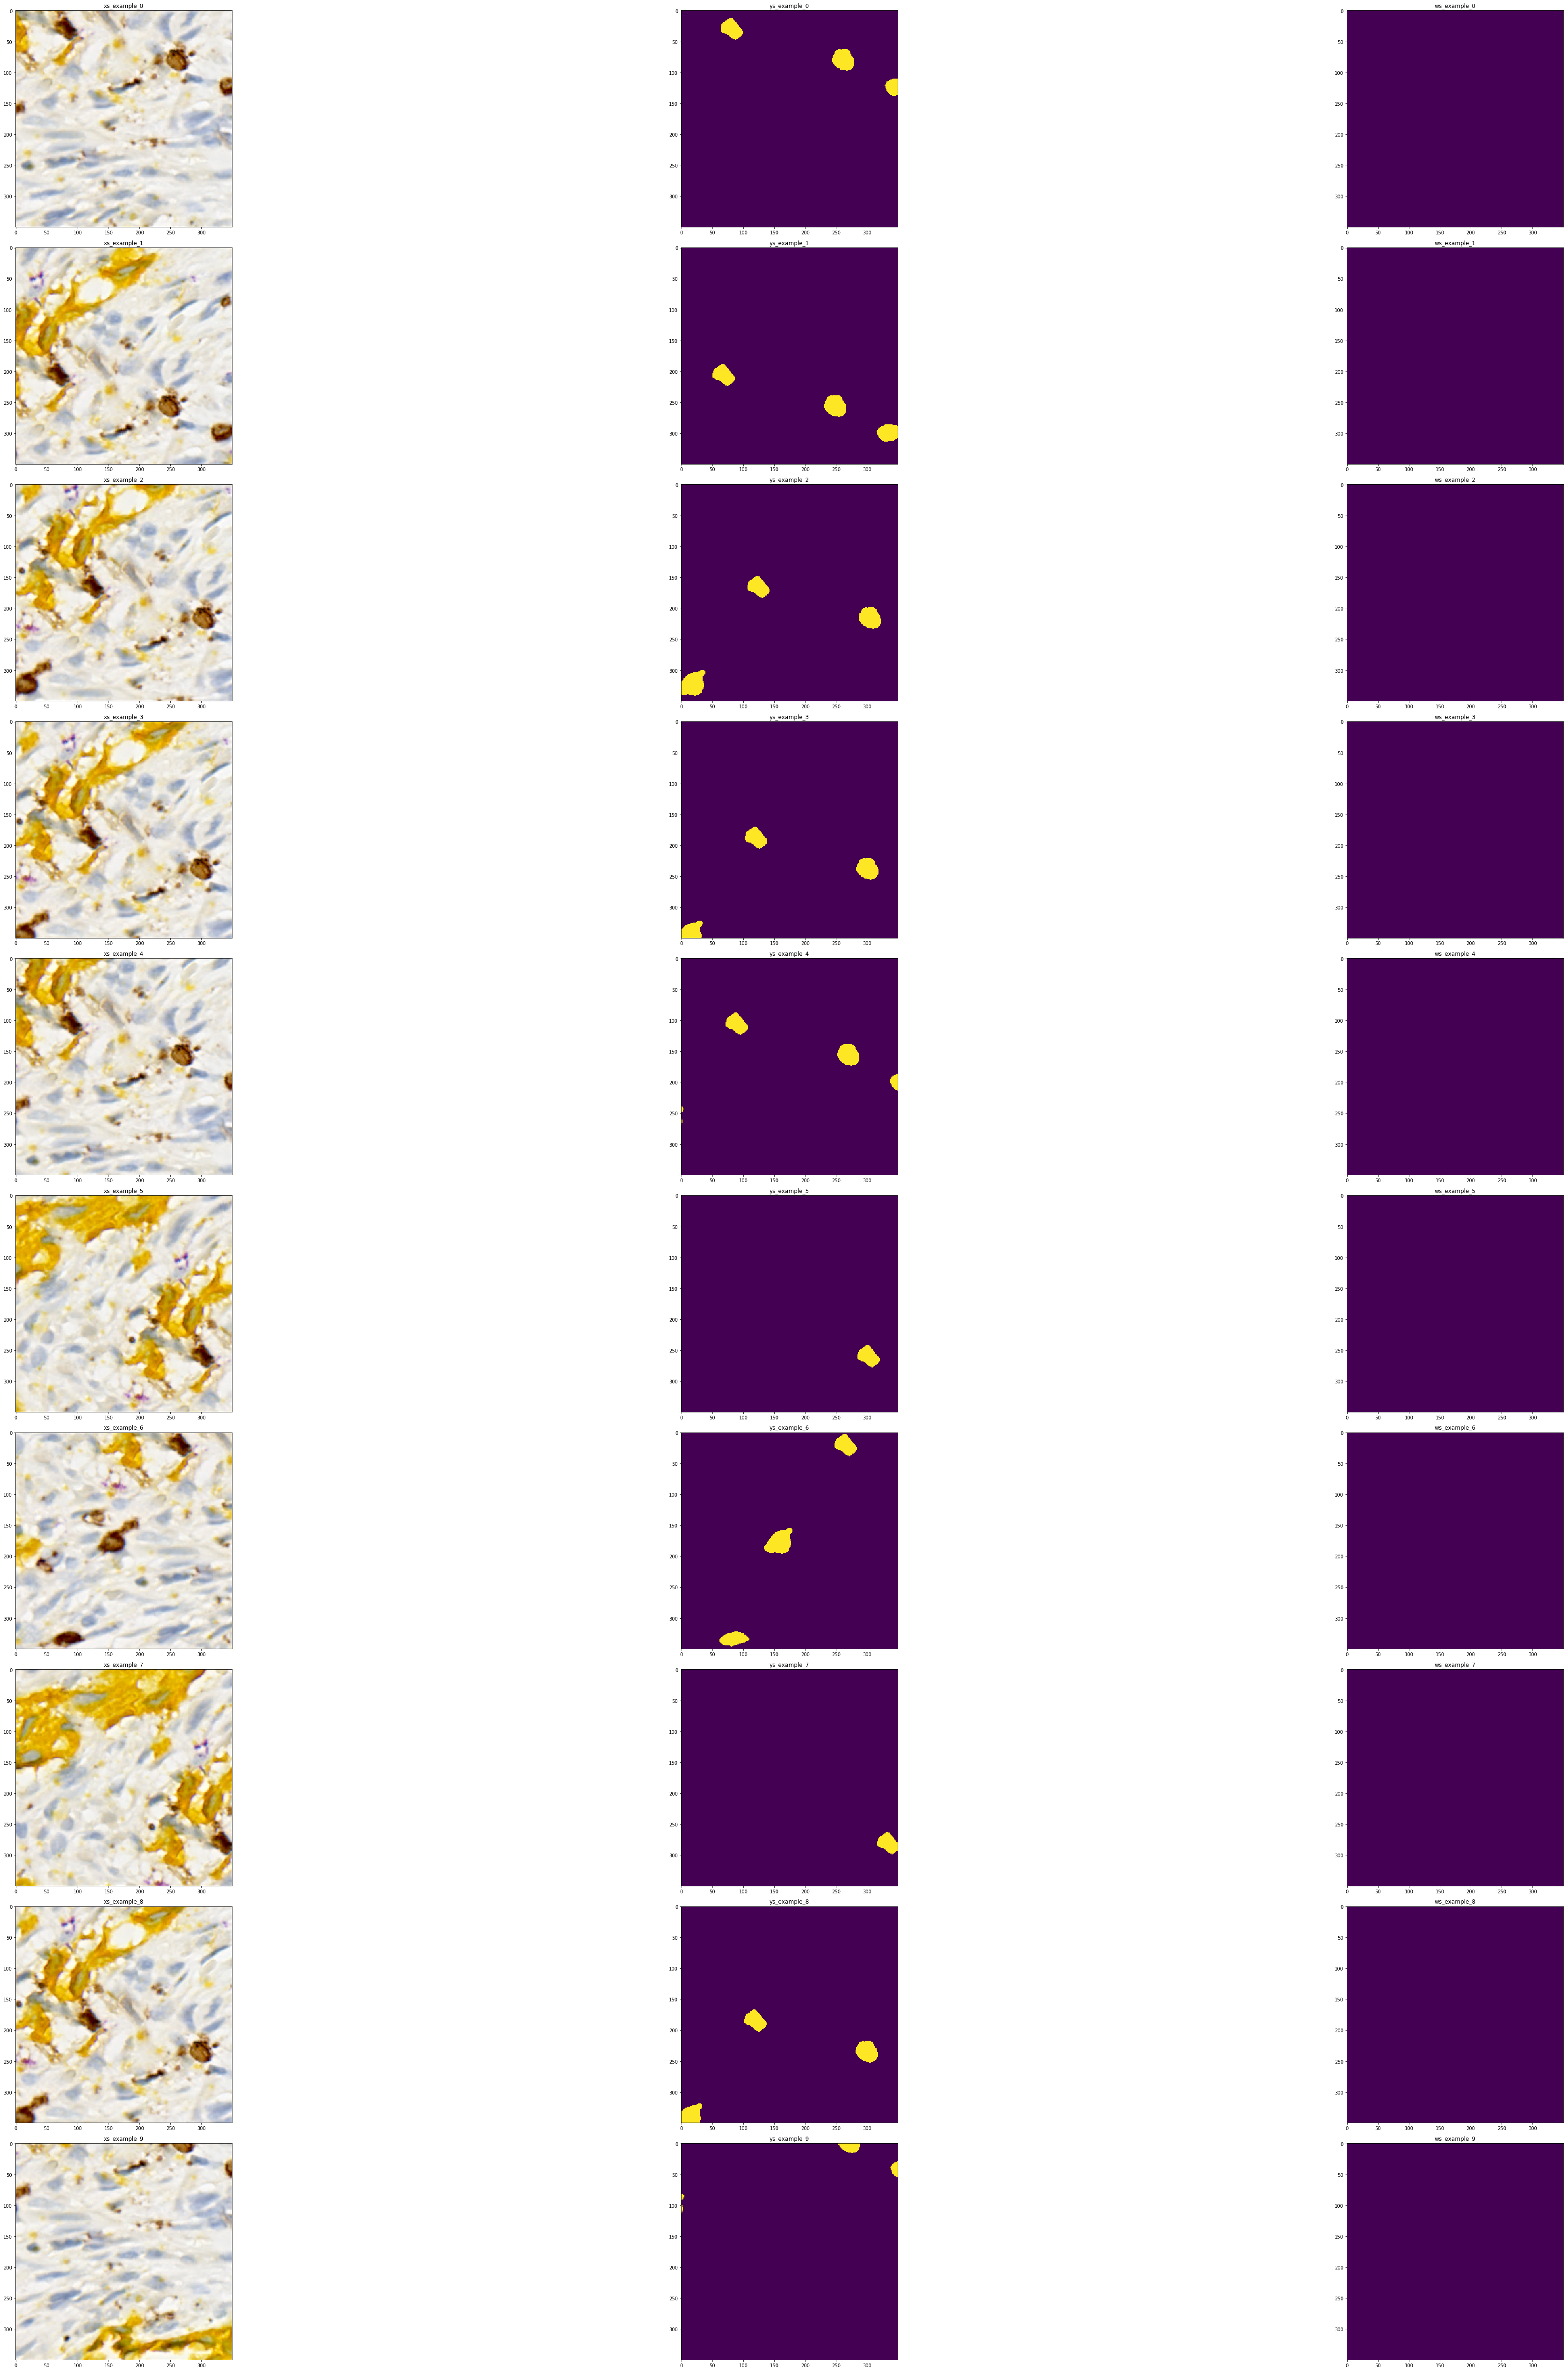

In [3]:

xs,ys,ws = dataset.sample_X_Y_patch_batch(input_patch_size,fit=False)
print("xs shape {}\nys shape {}\nxs type {}\nys type {}".format(xs.shape,
                                                                 ys.shape,
                                                                 xs.dtype,
                                                                 ys.dtype))

ys_imgs = from_categorical(ys)
show_batches([xs,ys_imgs,ws],["xs","ys","ws"])

# Training a model

In [13]:
# define your model
from datasets import combine_y_w

model_input_size = input_patch_size + input_channels
unet = Unet(model_input_size, classes=output_channels[0])

def train(model,dataset,epochs=10,n_batch=5):
    losses = None
    metrics = None
    h,w,_ = model.input_shape
    for i in range(epochs):
        x_train,y_train,w_train = dataset.sample_X_Y_patch_batch([h,w],n_batch=n_batch)
        yw_train = combine_y_w(y_train,w_train)
        model.fit(x_train,yw_train)
        model.evaluate(x_train,yw_train)
        loss, metric = model.score
        losses += [loss]
        metrics += [metric]
    return losses, metrics

train(unet,dataset)
        

(164, 164, 2)
(5, 164, 164, 2)
Epoch 1/1


KeyboardInterrupt: 